# Customer Churn Prediction - Comprehensive EDA

This notebook provides an in-depth exploratory data analysis of the music streaming platform event logs to understand customer behavior patterns and identify churn indicators.


In [35]:
# Import libraries and setup
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Custom imports
from data import ChurnDataLoader

# Configure plotting
plt.style.use('default')
sns.set_palette(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully")
print(f"📊 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📊 Analysis started at: 2025-12-25 12:42:28


# 1. Data Loading & Overview

In [26]:
# Load and preprocess data
loader = ChurnDataLoader(data_path='../data/')
df = loader.load_event_logs('customer_churn_mini.json')
df = loader.basic_preprocessing(df)

# Create comprehensive overview
print("🎵 MUSIC STREAMING PLATFORM - DATA OVERVIEW")
print("=" * 60)
print(f"📈 Total Events: {len(df):,}")
print(f"👥 Unique Users: {df['userId'].nunique():,}")
print(f"📅 Date Range: {df['ts'].min().date()} to {df['ts'].max().date()}")
print(f"⏱️  Duration: {(df['ts'].max() - df['ts'].min()).days} days")
print(f"🎵 Song Events: {len(df[df['page'] == 'NextSong']):,}")
print(f"📱 Unique Sessions: {df['sessionId'].nunique():,}")

# Basic data structure
print(f"\n📊 Data Shape: {df.shape}")
print(f"💾 Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Show data types
print(f"\n📋 Data Types:")
for col in df.columns:
    print(f"  • {col}: {df[col].dtype}")
    
# Sample data preview
print(f"\n👀 Sample Events:")
display(df.head(3))

INFO:data:Loading data from ..\data\customer_churn_mini.json
INFO:data:Loaded 286500 events for 226 unique users
INFO:data:Preprocessing complete. Shape: (286500, 18)


🎵 MUSIC STREAMING PLATFORM - DATA OVERVIEW
📈 Total Events: 286,500
👥 Unique Users: 226
📅 Date Range: 2018-10-01 to 2018-12-03
⏱️  Duration: 63 days
🎵 Song Events: 228,108
📱 Unique Sessions: 2,354

📊 Data Shape: (286500, 18)
💾 Memory Usage: 252.0 MB

📋 Data Types:
  • ts: datetime64[ns]
  • userId: object
  • sessionId: int64
  • page: object
  • auth: object
  • method: object
  • status: int64
  • level: object
  • itemInSession: int64
  • location: object
  • userAgent: object
  • lastName: object
  • firstName: object
  • registration: datetime64[ns]
  • gender: object
  • artist: object
  • song: object
  • length: float64

👀 Sample Events:


,ts,userId,sessionId,page,auth,method,status,level,itemInSession,location,userAgent,lastName,firstName,registration,gender,artist,song,length
57,2018-10-01 01:02:25,,8,Home,Logged Out,GET,200,free,100,Unknown,NaN,NaN,NaN,NaT,Unknown,NaN,NaN,NaN
58,2018-10-01 01:03:27,,8,Help,Logged Out,GET,200,free,101,Unknown,NaN,NaN,NaN,NaT,Unknown,NaN,NaN,NaN
59,2018-10-01 01:04:01,,8,Home,Logged Out,GET,200,free,102,Unknown,NaN,NaN,NaN,NaT,Unknown,NaN,NaN,NaN


🎯 EVENT TYPE ANALYSIS
Event Type                    Count  Percentage
-----------------------------------------------
NextSong                   228,108      79.6%
Home                        14,457       5.0%
Thumbs Up                   12,551       4.4%
Add to Playlist              6,526       2.3%
Add Friend                   4,277       1.5%
Roll Advert                  3,933       1.4%
Login                        3,241       1.1%
Logout                       3,226       1.1%
Thumbs Down                  2,546       0.9%
Downgrade                    2,055       0.7%


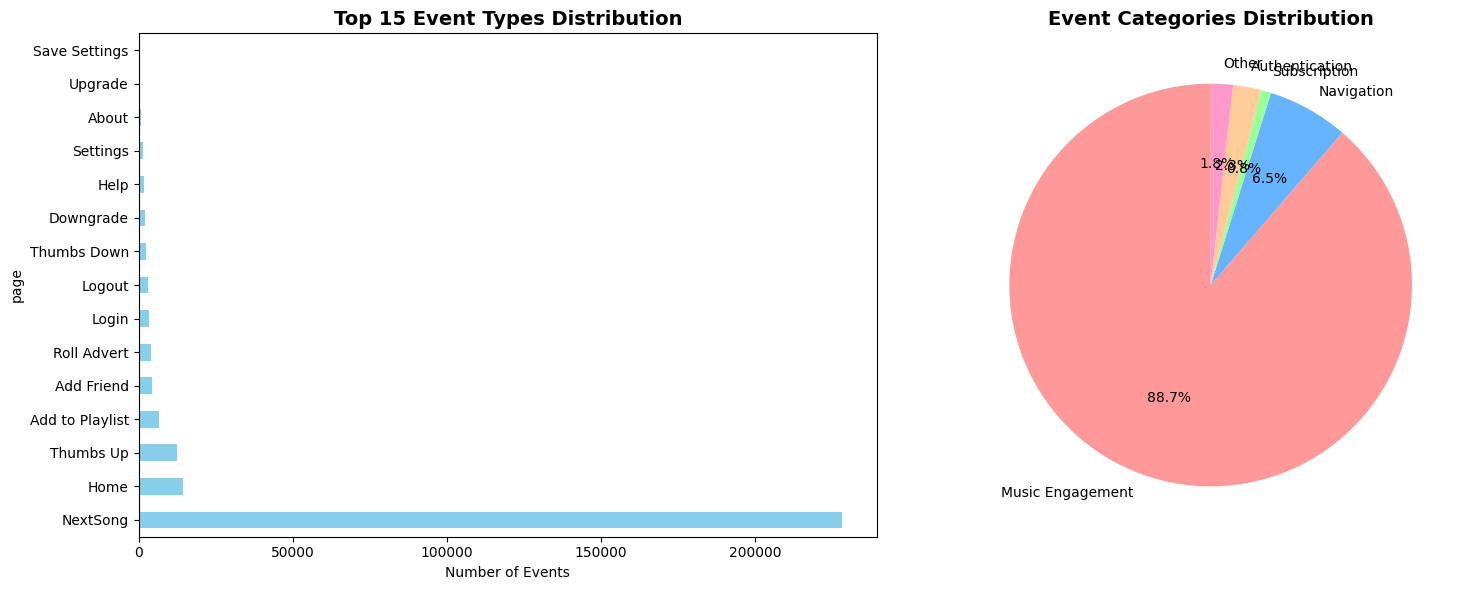


💡 Key Insights:
• Music engagement represents 88.7% of all activity
• 228,108 song play events indicate high user engagement
• 63 explicit downgrade submissions detected


In [16]:
# Event type analysis with business context
event_counts = df['page'].value_counts()
event_pct = (event_counts / len(df) * 100).round(2)

print("🎯 EVENT TYPE ANALYSIS")
print("=" * 50)
print("Event Type".ljust(25) + "Count".rjust(10) + "Percentage".rjust(12))
print("-" * 47)
for event, count in event_counts.head(10).items():
    pct = event_pct[event]
    print(f"{event[:24].ljust(25)}{count:>9,}{pct:>10.1f}%")

# Categorize events by business value
engagement_events = ['NextSong', 'Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Add Friend']
navigation_events = ['Home', 'Help', 'Settings', 'About']
subscription_events = ['Submit Downgrade', 'Downgrade', 'Submit Registration', 'Submit Upgrade']
auth_events = ['Login', 'Logout', 'Register']

# Calculate event category distributions
categories = {
    'Music Engagement': df[df['page'].isin(engagement_events)].shape[0],
    'Navigation': df[df['page'].isin(navigation_events)].shape[0],
    'Subscription': df[df['page'].isin(subscription_events)].shape[0],
    'Authentication': df[df['page'].isin(auth_events)].shape[0],
    'Other': df[~df['page'].isin(engagement_events + navigation_events + subscription_events + auth_events)].shape[0]
}

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Event type distribution
event_counts.head(15).plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 15 Event Types Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Events')

# Event category pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']
axes[1].pie(categories.values(), labels=categories.keys(), autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Event Categories Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 Key Insights:")
print(f"• Music engagement represents {categories['Music Engagement']/len(df)*100:.1f}% of all activity")
print(f"• {event_counts['NextSong']:,} song play events indicate high user engagement")
print(f"• {event_counts.get('Submit Downgrade', 0)} explicit downgrade submissions detected")

# 2. User Demographics & Segmentation

👥 USER DEMOGRAPHICS & BEHAVIOR

🚻 Gender Distribution:
  • M: 121 (53.5%)
  • F: 104 (46.0%)
  • Unknown: 1 (0.4%)

💳 Subscription Levels:
  • Paid: 140 (61.9%)
  • Free: 86 (38.1%)

📊 User Activity Segments:
  • Medium Activity: 104 users (avg: 477 events)
  • High Activity: 100 users (avg: 2357 events)
  • Low Activity: 22 users (avg: 53 events)


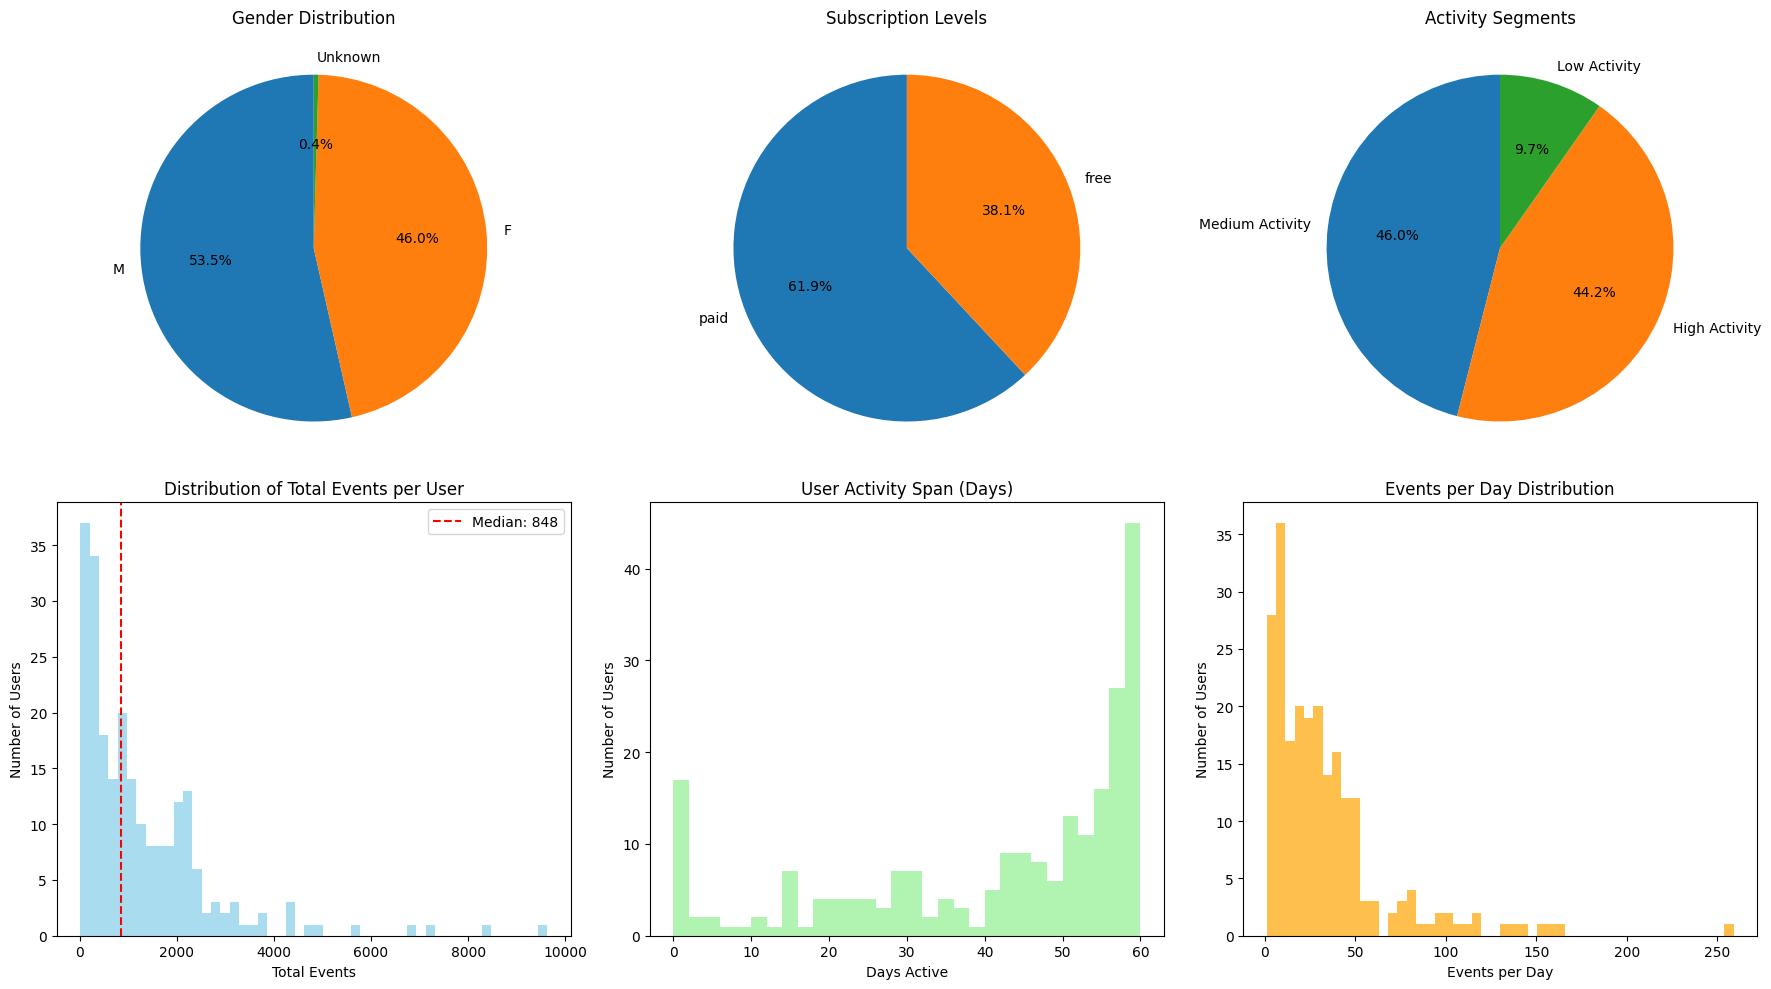


📈 Key Statistics:
• Median events per user: 848
• Average activity span: 41.2 days
• Most active user: 9,632 events
• Registered users: 225 (99.6%)


In [17]:
# User demographics and subscription analysis
user_summary = df.groupby('userId').agg({
    'ts': ['count', 'min', 'max'],
    'sessionId': 'nunique',
    'level': lambda x: x.value_counts().index[0],  # Most common level
    'gender': 'first',
    'location': 'first',
    'registration': 'first'
}).reset_index()

# Flatten column names
user_summary.columns = ['userId', 'total_events', 'first_activity', 'last_activity', 
                       'unique_sessions', 'primary_level', 'gender', 'location', 'registration']

# Calculate activity metrics
user_summary['activity_span_days'] = (user_summary['last_activity'] - user_summary['first_activity']).dt.days
user_summary['events_per_day'] = user_summary['total_events'] / (user_summary['activity_span_days'] + 1)
user_summary['days_since_registration'] = (df['ts'].max() - user_summary['registration']).dt.days

print("👥 USER DEMOGRAPHICS & BEHAVIOR")
print("=" * 50)

# Gender distribution
gender_dist = user_summary['gender'].value_counts()
print(f"\n🚻 Gender Distribution:")
for gender, count in gender_dist.items():
    print(f"  • {gender}: {count} ({count/len(user_summary)*100:.1f}%)")

# Subscription level distribution  
level_dist = user_summary['primary_level'].value_counts()
print(f"\n💳 Subscription Levels:")
for level, count in level_dist.items():
    print(f"  • {level.title()}: {count} ({count/len(user_summary)*100:.1f}%)")

# Activity level segmentation
def categorize_user_activity(events):
    if events < 100:
        return 'Low Activity'
    elif events < 1000:
        return 'Medium Activity'
    else:
        return 'High Activity'

user_summary['activity_segment'] = user_summary['total_events'].apply(categorize_user_activity)
activity_dist = user_summary['activity_segment'].value_counts()

print(f"\n📊 User Activity Segments:")
for segment, count in activity_dist.items():
    avg_events = user_summary[user_summary['activity_segment'] == segment]['total_events'].mean()
    print(f"  • {segment}: {count} users (avg: {avg_events:.0f} events)")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Gender distribution
axes[0,0].pie(gender_dist.values, labels=gender_dist.index, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Gender Distribution')

# Subscription level distribution
axes[0,1].pie(level_dist.values, labels=level_dist.index, autopct='%1.1f%%', startangle=90)
axes[0,1].set_title('Subscription Levels')

# Activity segments
axes[0,2].pie(activity_dist.values, labels=activity_dist.index, autopct='%1.1f%%', startangle=90)
axes[0,2].set_title('Activity Segments')

# Total events distribution
axes[1,0].hist(user_summary['total_events'], bins=50, alpha=0.7, color='skyblue')
axes[1,0].set_title('Distribution of Total Events per User')
axes[1,0].set_xlabel('Total Events')
axes[1,0].set_ylabel('Number of Users')
axes[1,0].axvline(user_summary['total_events'].median(), color='red', linestyle='--', 
                  label=f'Median: {user_summary["total_events"].median():.0f}')
axes[1,0].legend()

# Activity span distribution
axes[1,1].hist(user_summary['activity_span_days'], bins=30, alpha=0.7, color='lightgreen')
axes[1,1].set_title('User Activity Span (Days)')
axes[1,1].set_xlabel('Days Active')
axes[1,1].set_ylabel('Number of Users')

# Events per day distribution
axes[1,2].hist(user_summary['events_per_day'], bins=50, alpha=0.7, color='orange')
axes[1,2].set_title('Events per Day Distribution')
axes[1,2].set_xlabel('Events per Day')
axes[1,2].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()

print(f"\n📈 Key Statistics:")
print(f"• Median events per user: {user_summary['total_events'].median():.0f}")
print(f"• Average activity span: {user_summary['activity_span_days'].mean():.1f} days")  
print(f"• Most active user: {user_summary['total_events'].max():,} events")
print(f"• Registered users: {user_summary['registration'].notna().sum()} ({user_summary['registration'].notna().mean()*100:.1f}%)")

In [27]:
# Geographic analysis
location_analysis = user_summary['location'].value_counts()
print("🌍 GEOGRAPHIC DISTRIBUTION")
print("=" * 40)
print("\nTop 10 Locations:")
for i, (location, count) in enumerate(location_analysis.head(10).items()):
    print(f"{i+1:2d}. {location}: {count} users")

# Extract states from location (format: "City, STATE")
def extract_state(location):
    if pd.isna(location) or location == 'Unknown':
        return 'Unknown'
    parts = location.split(', ')
    return parts[-1] if len(parts) > 1 else 'Unknown'

user_summary['state'] = user_summary['location'].apply(extract_state)
state_dist = user_summary['state'].value_counts()

print(f"\n🗺️ Top States:")
for state, count in state_dist.head(10).items():
    print(f"  • {state}: {count} users")

# Subscription analysis by demographics
print(f"\n💳 SUBSCRIPTION BY DEMOGRAPHICS")
print("=" * 40)

# Subscription by gender
sub_gender = pd.crosstab(user_summary['gender'], user_summary['primary_level'], normalize='index') * 100
print(f"\nSubscription Level by Gender (%):")
display(sub_gender.round(1))

# Subscription by activity segment  
sub_activity = pd.crosstab(user_summary['activity_segment'], user_summary['primary_level'], normalize='index') * 100
print(f"\nSubscription Level by Activity Segment (%):")
display(sub_activity.round(1))

🌍 GEOGRAPHIC DISTRIBUTION

Top 10 Locations:
 1. Los Angeles-Long Beach-Anaheim, CA: 16 users
 2. New York-Newark-Jersey City, NY-NJ-PA: 15 users
 3. Dallas-Fort Worth-Arlington, TX: 7 users
 4. Phoenix-Mesa-Scottsdale, AZ: 7 users
 5. Charlotte-Concord-Gastonia, NC-SC: 6 users
 6. St. Louis, MO-IL: 6 users
 7. Chicago-Naperville-Elgin, IL-IN-WI: 6 users
 8. Miami-Fort Lauderdale-West Palm Beach, FL: 5 users
 9. Boston-Cambridge-Newton, MA-NH: 5 users
10. Philadelphia-Camden-Wilmington, PA-NJ-DE-MD: 5 users

🗺️ Top States:
  • CA: 33 users
  • TX: 16 users
  • NY-NJ-PA: 15 users
  • FL: 14 users
  • CT: 7 users
  • AZ: 7 users
  • NC-SC: 6 users
  • NC: 6 users
  • MO-IL: 6 users
  • IL-IN-WI: 6 users

💳 SUBSCRIPTION BY DEMOGRAPHICS

Subscription Level by Gender (%):


primary_level,free,paid
gender,,
F,31.7,68.3
M,43.8,56.2
Unknown,0.0,100.0



Subscription Level by Activity Segment (%):


primary_level,free,paid
activity_segment,,
High Activity,10.0,90.0
Low Activity,90.9,9.1
Medium Activity,53.8,46.2


# 3. Music Engagement Analysis

🎵 MUSIC ENGAGEMENT ANALYSIS
📊 Total song plays: 228,108
🎤 Unique artists: 17,655
🎶 Unique songs: 58,480
⏱️  Average song length: 249.1 seconds
📅 Song plays per day: 3621

🎤 Top 10 Artists:
 1. Kings Of Leon: 1,841 plays
 2. Coldplay: 1,813 plays
 3. Florence + The Machine: 1,236 plays
 4. Dwight Yoakam: 1,135 plays
 5. BjÃÂ¶rk: 1,133 plays
 6. The Black Keys: 1,125 plays
 7. Muse: 1,090 plays
 8. Justin Bieber: 1,044 plays
 9. Jack Johnson: 1,007 plays
10. Eminem: 953 plays

🎶 Top 10 Songs:
 1. You're The One - Dwight Yoakam: 1122 plays
 2. Undo - BjÃÂ¶rk: 1026 plays
 3. Revelry - Kings Of Leon: 854 plays
 4. Sehr kosmisch - Harmonia: 728 plays
 5. Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) - Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner: 641 plays
 6. Dog Days Are Over (Radio Edit) - Florence + The Machine: 574 plays
 7. Secrets - OneRepublic: 463 plays
 8. Use Somebody - Kings Of Leon: 459 plays
 9. Canada - Five Iron Frenzy: 434 pl

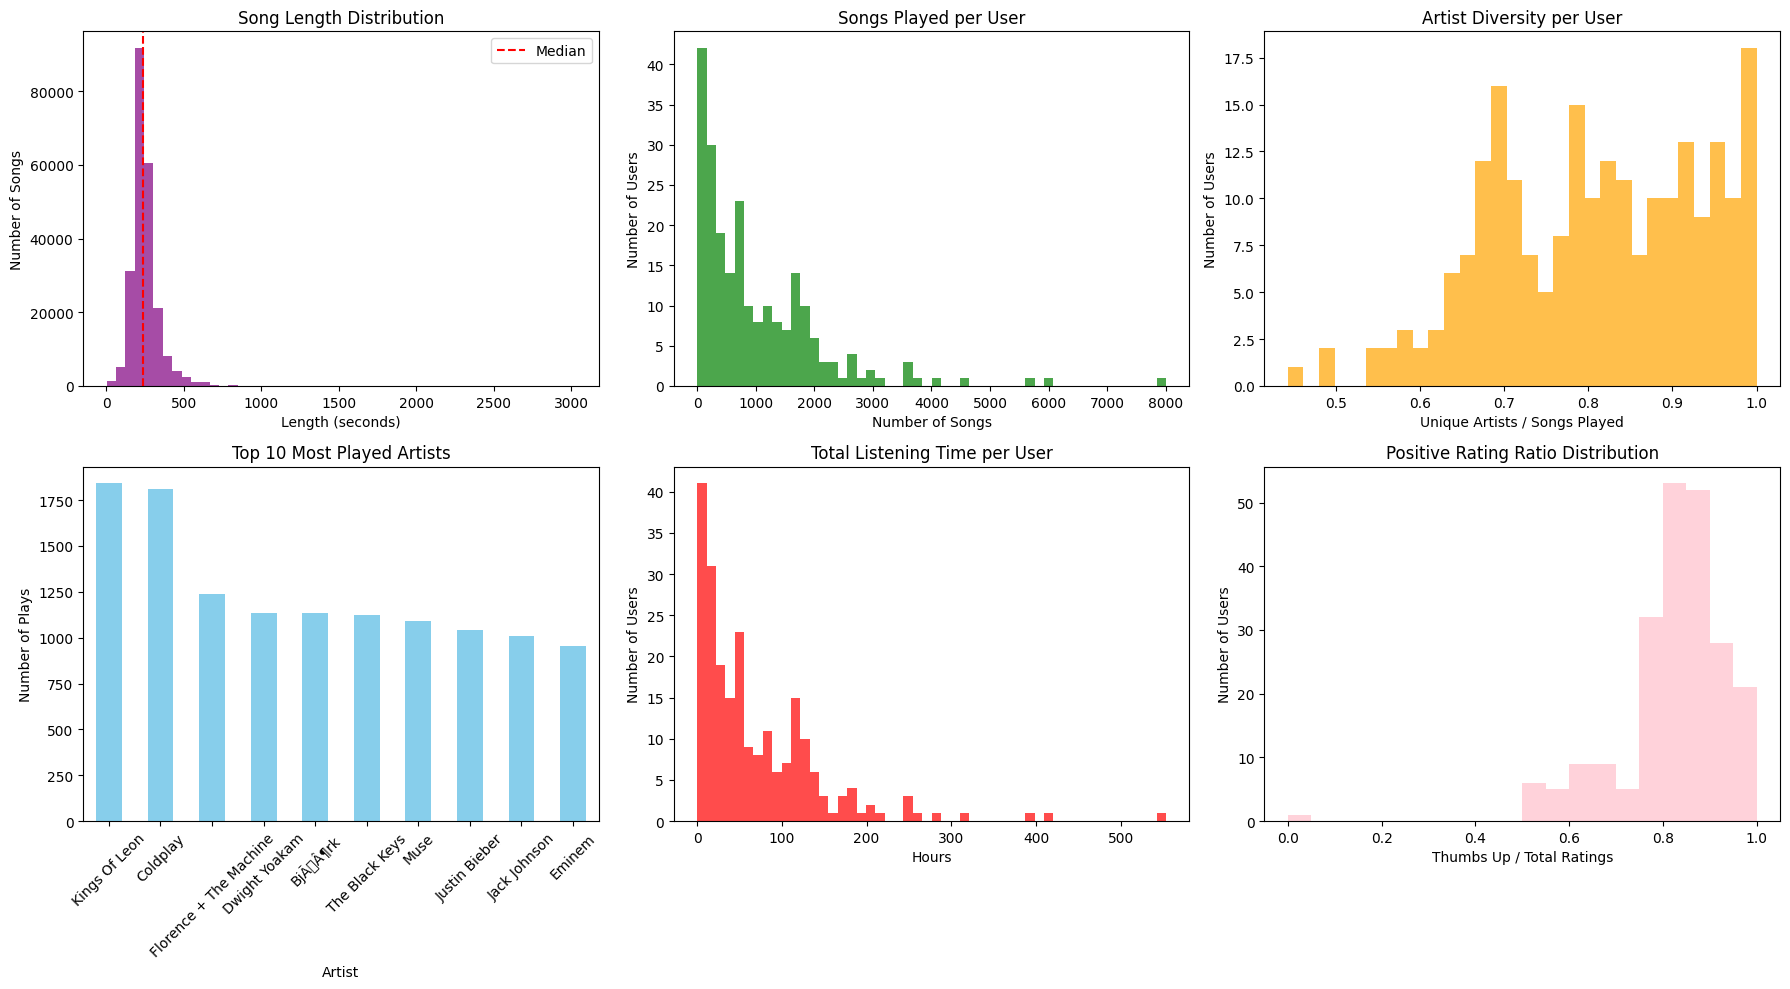


🎯 Music Engagement Insights:
• Average songs per user: 1013.8
• Most diverse listener: 1.000 (unique artists per song)
• Average listening time per user: 70.2 hours
• Users who rate songs: 221 (97.8%)
• Average positive rating ratio: 0.823


In [28]:
# Analyze music listening patterns and engagement
songs_df = df[df['page'] == 'NextSong'].copy()
songs_df = songs_df.dropna(subset=['artist', 'song', 'length'])

print("🎵 MUSIC ENGAGEMENT ANALYSIS")
print("=" * 50)
print(f"📊 Total song plays: {len(songs_df):,}")
print(f"🎤 Unique artists: {songs_df['artist'].nunique():,}")
print(f"🎶 Unique songs: {songs_df['song'].nunique():,}")
print(f"⏱️  Average song length: {songs_df['length'].mean():.1f} seconds")
print(f"📅 Song plays per day: {len(songs_df)/((df['ts'].max() - df['ts'].min()).days):.0f}")

# Top artists and songs
print(f"\n🎤 Top 10 Artists:")
top_artists = songs_df['artist'].value_counts().head(10)
for i, (artist, plays) in enumerate(top_artists.items()):
    print(f"{i+1:2d}. {artist}: {plays:,} plays")

print(f"\n🎶 Top 10 Songs:")
top_songs = songs_df.groupby(['artist', 'song']).size().sort_values(ascending=False).head(10)
for i, ((artist, song), plays) in enumerate(top_songs.items()):
    print(f"{i+1:2d}. {song} - {artist}: {plays} plays")

# User engagement patterns
user_music = songs_df.groupby('userId').agg({
    'artist': 'nunique',
    'song': 'nunique', 
    'length': ['count', 'mean', 'sum']
}).reset_index()

user_music.columns = ['userId', 'unique_artists', 'unique_songs', 'songs_played', 'avg_song_length', 'total_listening_time']
user_music['artist_diversity'] = user_music['unique_artists'] / user_music['songs_played']
user_music['song_diversity'] = user_music['unique_songs'] / user_music['songs_played']

# Engagement analysis
engagement_df = df[df['page'].isin(['Thumbs Up', 'Thumbs Down'])].copy()
user_engagement = engagement_df.groupby('userId')['page'].value_counts().unstack(fill_value=0)
if 'Thumbs Up' not in user_engagement.columns:
    user_engagement['Thumbs Up'] = 0
if 'Thumbs Down' not in user_engagement.columns:
    user_engagement['Thumbs Down'] = 0
    
user_engagement['total_ratings'] = user_engagement['Thumbs Up'] + user_engagement['Thumbs Down']
user_engagement['positive_ratio'] = np.where(user_engagement['total_ratings'] > 0,
                                           user_engagement['Thumbs Up'] / user_engagement['total_ratings'], 
                                           np.nan)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Song length distribution
axes[0,0].hist(songs_df['length'], bins=50, alpha=0.7, color='purple')
axes[0,0].set_title('Song Length Distribution')
axes[0,0].set_xlabel('Length (seconds)')
axes[0,0].set_ylabel('Number of Songs')
axes[0,0].axvline(songs_df['length'].median(), color='red', linestyle='--', label='Median')
axes[0,0].legend()

# Songs per user
axes[0,1].hist(user_music['songs_played'], bins=50, alpha=0.7, color='green')
axes[0,1].set_title('Songs Played per User')
axes[0,1].set_xlabel('Number of Songs')
axes[0,1].set_ylabel('Number of Users')

# Artist diversity
axes[0,2].hist(user_music['artist_diversity'], bins=30, alpha=0.7, color='orange')
axes[0,2].set_title('Artist Diversity per User')
axes[0,2].set_xlabel('Unique Artists / Songs Played')
axes[0,2].set_ylabel('Number of Users')

# Top artists bar chart
top_artists.plot(kind='bar', ax=axes[1,0], color='skyblue')
axes[1,0].set_title('Top 10 Most Played Artists')
axes[1,0].set_xlabel('Artist')
axes[1,0].set_ylabel('Number of Plays')
axes[1,0].tick_params(axis='x', rotation=45)

# Listening time per user
total_time_hours = user_music['total_listening_time'] / 3600
axes[1,1].hist(total_time_hours, bins=50, alpha=0.7, color='red')
axes[1,1].set_title('Total Listening Time per User')
axes[1,1].set_xlabel('Hours')
axes[1,1].set_ylabel('Number of Users')

# Positive rating ratio
valid_ratings = user_engagement['positive_ratio'].dropna()
if len(valid_ratings) > 0:
    axes[1,2].hist(valid_ratings, bins=20, alpha=0.7, color='pink')
    axes[1,2].set_title('Positive Rating Ratio Distribution')
    axes[1,2].set_xlabel('Thumbs Up / Total Ratings')
    axes[1,2].set_ylabel('Number of Users')
else:
    axes[1,2].text(0.5, 0.5, 'No Rating Data', transform=axes[1,2].transAxes, ha='center', va='center')
    axes[1,2].set_title('Positive Rating Ratio Distribution')

plt.tight_layout()
plt.show()

print(f"\n🎯 Music Engagement Insights:")
print(f"• Average songs per user: {user_music['songs_played'].mean():.1f}")
print(f"• Most diverse listener: {user_music['artist_diversity'].max():.3f} (unique artists per song)")
print(f"• Average listening time per user: {(user_music['total_listening_time'].mean()/3600):.1f} hours")
if len(valid_ratings) > 0:
    print(f"• Users who rate songs: {len(valid_ratings)} ({len(valid_ratings)/len(user_summary)*100:.1f}%)")
    print(f"• Average positive rating ratio: {valid_ratings.mean():.3f}")

# 4. Temporal Patterns & Seasonality

⏰ TEMPORAL PATTERNS ANALYSIS
📊 Daily Activity Summary:
  • Average daily users: 50.6
  • Average daily events: 4548
  • Average events per user per day: 87.5
  • Peak activity day: 2018-11-02 (7,568 events)
  • Lowest activity day: 2018-12-03 (1 events)

🔄 Peak Usage Patterns:
  • Peak hour: 16:00 (14,686 events)
  • Quiet hour: 7:00 (10,068 events)
  • Most active day: Friday (49,522 events)
  • Least active day: Sunday (21,656 events)


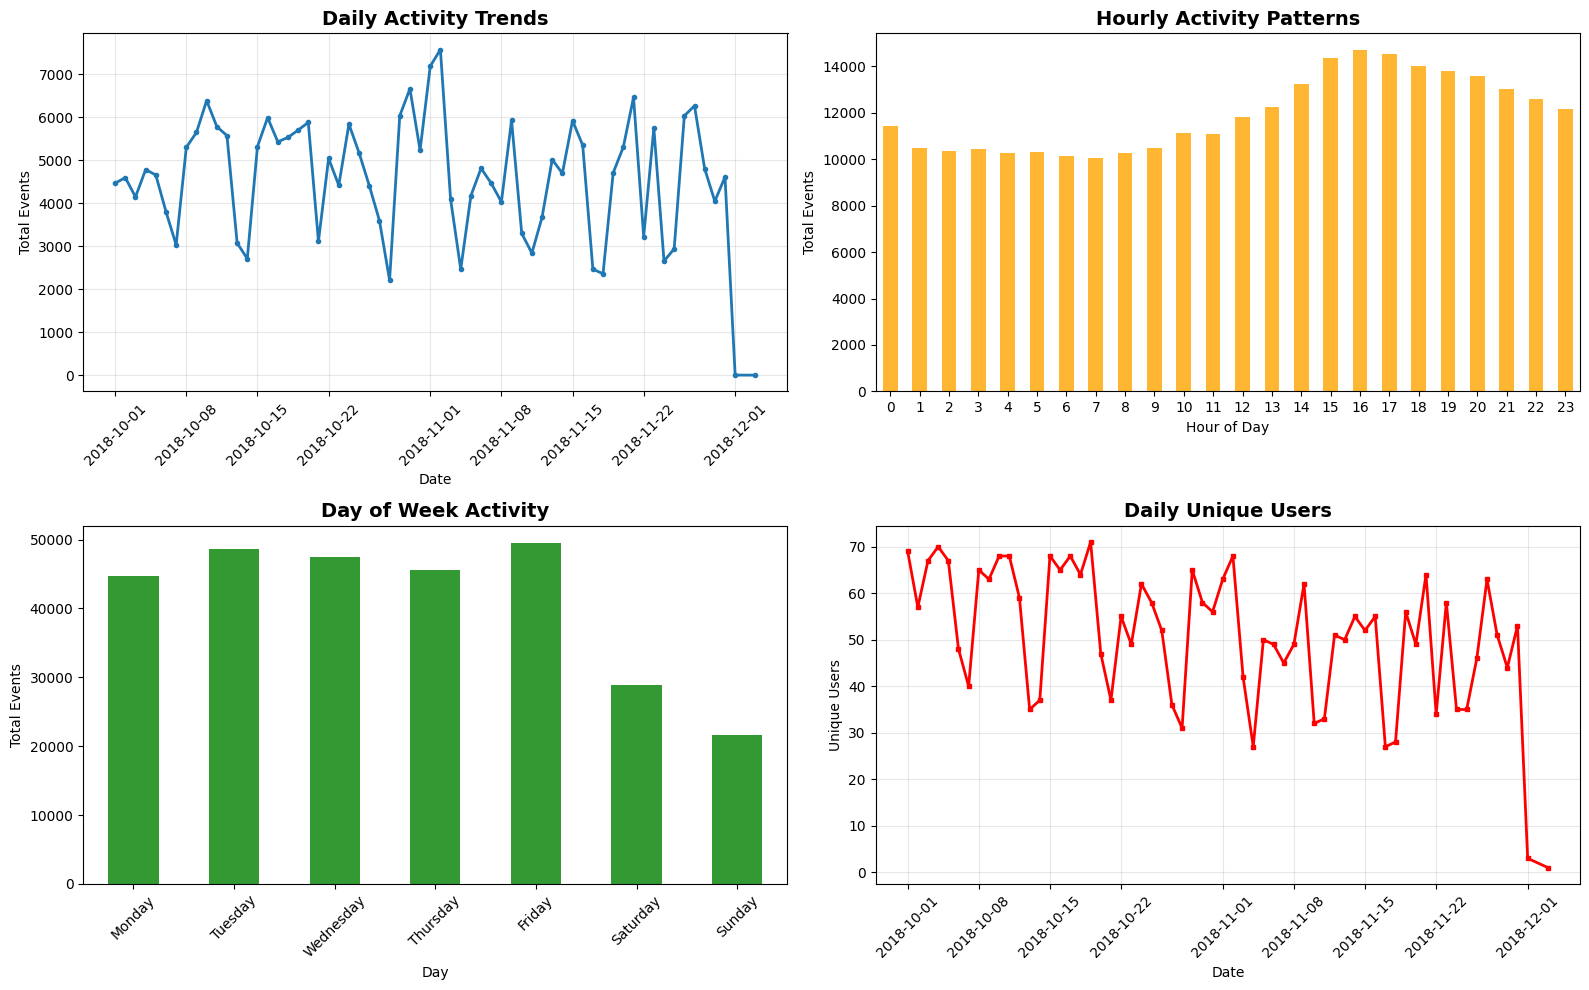


📱 SESSION ANALYSIS:
  • Total sessions: 2,354
  • Average session length: 9312.7 minutes
  • Average events per session: 121.7
  • Average songs per session: 96.9
  • Longest session: 87739.1 minutes

📉 USER ACTIVITY TRENDS:
  • Active in last 7 days: 123 users (54.4%)
  • Active in last 30 days: 185 users (81.9%)
  • Active in last 60 days: 224 users (99.1%)


In [29]:
# Temporal analysis - activity patterns over time
df['date'] = df['ts'].dt.date
df['hour'] = df['ts'].dt.hour  
df['day_of_week'] = df['ts'].dt.day_name()
df['week'] = df['ts'].dt.isocalendar().week

print("⏰ TEMPORAL PATTERNS ANALYSIS")
print("=" * 50)

# Daily activity trends
daily_stats = df.groupby('date').agg({
    'userId': 'nunique',
    'ts': 'count',
    'sessionId': 'nunique',
    'page': lambda x: (x == 'NextSong').sum()  # Song plays
}).rename(columns={
    'userId': 'unique_users',
    'ts': 'total_events', 
    'sessionId': 'unique_sessions',
    'page': 'song_plays'
})

daily_stats['events_per_user'] = daily_stats['total_events'] / daily_stats['unique_users']
daily_stats['songs_per_user'] = daily_stats['song_plays'] / daily_stats['unique_users']

print(f"📊 Daily Activity Summary:")
print(f"  • Average daily users: {daily_stats['unique_users'].mean():.1f}")
print(f"  • Average daily events: {daily_stats['total_events'].mean():.0f}")
print(f"  • Average events per user per day: {daily_stats['events_per_user'].mean():.1f}")
print(f"  • Peak activity day: {daily_stats['total_events'].idxmax()} ({daily_stats['total_events'].max():,} events)")
print(f"  • Lowest activity day: {daily_stats['total_events'].idxmin()} ({daily_stats['total_events'].min():,} events)")

# Hourly patterns
hourly_stats = df.groupby('hour').agg({
    'userId': 'nunique',
    'ts': 'count'
}).rename(columns={'userId': 'unique_users', 'ts': 'total_events'})

# Day of week patterns
dow_stats = df.groupby('day_of_week').agg({
    'userId': 'nunique', 
    'ts': 'count'
}).rename(columns={'userId': 'unique_users', 'ts': 'total_events'})

# Reorder days
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_stats = dow_stats.reindex(dow_order)

# Weekly trends
weekly_stats = df.groupby('week').agg({
    'userId': 'nunique',
    'ts': 'count'
}).rename(columns={'userId': 'unique_users', 'ts': 'total_events'})

print(f"\n🔄 Peak Usage Patterns:")
print(f"  • Peak hour: {hourly_stats['total_events'].idxmax()}:00 ({hourly_stats['total_events'].max():,} events)")
print(f"  • Quiet hour: {hourly_stats['total_events'].idxmin()}:00 ({hourly_stats['total_events'].min():,} events)")
print(f"  • Most active day: {dow_stats['total_events'].idxmax()} ({dow_stats['total_events'].max():,} events)")
print(f"  • Least active day: {dow_stats['total_events'].idxmin()} ({dow_stats['total_events'].min():,} events)")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Daily trends
axes[0,0].plot(daily_stats.index, daily_stats['total_events'], marker='o', linewidth=2, markersize=3)
axes[0,0].set_title('Daily Activity Trends', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Date')
axes[0,0].set_ylabel('Total Events')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Hourly patterns
hourly_stats['total_events'].plot(kind='bar', ax=axes[0,1], color='orange', alpha=0.8)
axes[0,1].set_title('Hourly Activity Patterns', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Hour of Day')
axes[0,1].set_ylabel('Total Events')
axes[0,1].tick_params(axis='x', rotation=0)

# Day of week patterns
dow_stats['total_events'].plot(kind='bar', ax=axes[1,0], color='green', alpha=0.8)
axes[1,0].set_title('Day of Week Activity', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Day')
axes[1,0].set_ylabel('Total Events')
axes[1,0].tick_params(axis='x', rotation=45)

# User activity over time
axes[1,1].plot(daily_stats.index, daily_stats['unique_users'], marker='s', linewidth=2, markersize=3, color='red')
axes[1,1].set_title('Daily Unique Users', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Date')
axes[1,1].set_ylabel('Unique Users')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Session patterns
print(f"\n📱 SESSION ANALYSIS:")
session_stats = df.groupby('sessionId').agg({
    'ts': ['count', 'min', 'max'],
    'userId': 'first',
    'page': lambda x: (x == 'NextSong').sum()
}).reset_index()

session_stats.columns = ['sessionId', 'events_count', 'start_time', 'end_time', 'userId', 'songs_played']
session_stats['duration_minutes'] = (session_stats['end_time'] - session_stats['start_time']).dt.total_seconds() / 60

print(f"  • Total sessions: {len(session_stats):,}")
print(f"  • Average session length: {session_stats['duration_minutes'].mean():.1f} minutes")
print(f"  • Average events per session: {session_stats['events_count'].mean():.1f}")
print(f"  • Average songs per session: {session_stats['songs_played'].mean():.1f}")
print(f"  • Longest session: {session_stats['duration_minutes'].max():.1f} minutes")

# User activity decline analysis
print(f"\n📉 USER ACTIVITY TRENDS:")
user_last_activity = df.groupby('userId')['ts'].max()
analysis_date = df['ts'].max()
days_since_last = (analysis_date - user_last_activity).dt.days

inactive_7d = (days_since_last <= 7).sum()
inactive_30d = (days_since_last <= 30).sum()
inactive_60d = (days_since_last <= 60).sum()

print(f"  • Active in last 7 days: {inactive_7d} users ({inactive_7d/len(user_summary)*100:.1f}%)")
print(f"  • Active in last 30 days: {inactive_30d} users ({inactive_30d/len(user_summary)*100:.1f}%)")
print(f"  • Active in last 60 days: {inactive_60d} users ({inactive_60d/len(user_summary)*100:.1f}%)")

# 5. Churn Signals & Risk Analysis

⚠️  CHURN SIGNALS & RISK ANALYSIS
🚨 Explicit Churn Signals:
  • Users with downgrade events: 154 (68.1%)
  • Users who submitted downgrades: 49 (21.7%)
  • Total downgrade events: 2,118


INFO:churn_definition:Found 154 users with explicit churn signals


  • Users with subscription changes: 136 (60.2%)


INFO:churn_definition:Found 1 users with subscription churn
INFO:churn_definition:Found 45 users with inactivity churn



🎯 Churn Classification (30-day inactivity threshold):
  • explicit: 154 users (68.1%)
  • not_churned: 52 users (23.0%)
  • inactivity: 20 users (8.8%)

📊 Overall Churn Rate: 174/226 = 77.0%

🎯 User Risk Distribution:
  • Medium Risk: 142 users (62.8%)
  • Low Risk: 46 users (20.4%)
  • No Risk: 37 users (16.4%)
  • High Risk: 1 users (0.4%)

📊 CHURNED vs ACTIVE USER COMPARISON:
Metric                    Churned (Avg)   Active (Avg)    Difference
----------------------------------------------------------------------
total_events              1512.5          448.6           +237.2%
unique_sessions           16.3            38.0            -57.2%
activity_span_days        41.4            40.4            +2.6%
events_per_day            38.9            14.9            +161.7%

Available subscription levels: ['paid' 'free']

Churn by Subscription Level:
  • Paid users: 134/140 churned (95.7%)
  • Free users: 40/86 churned (46.5%)


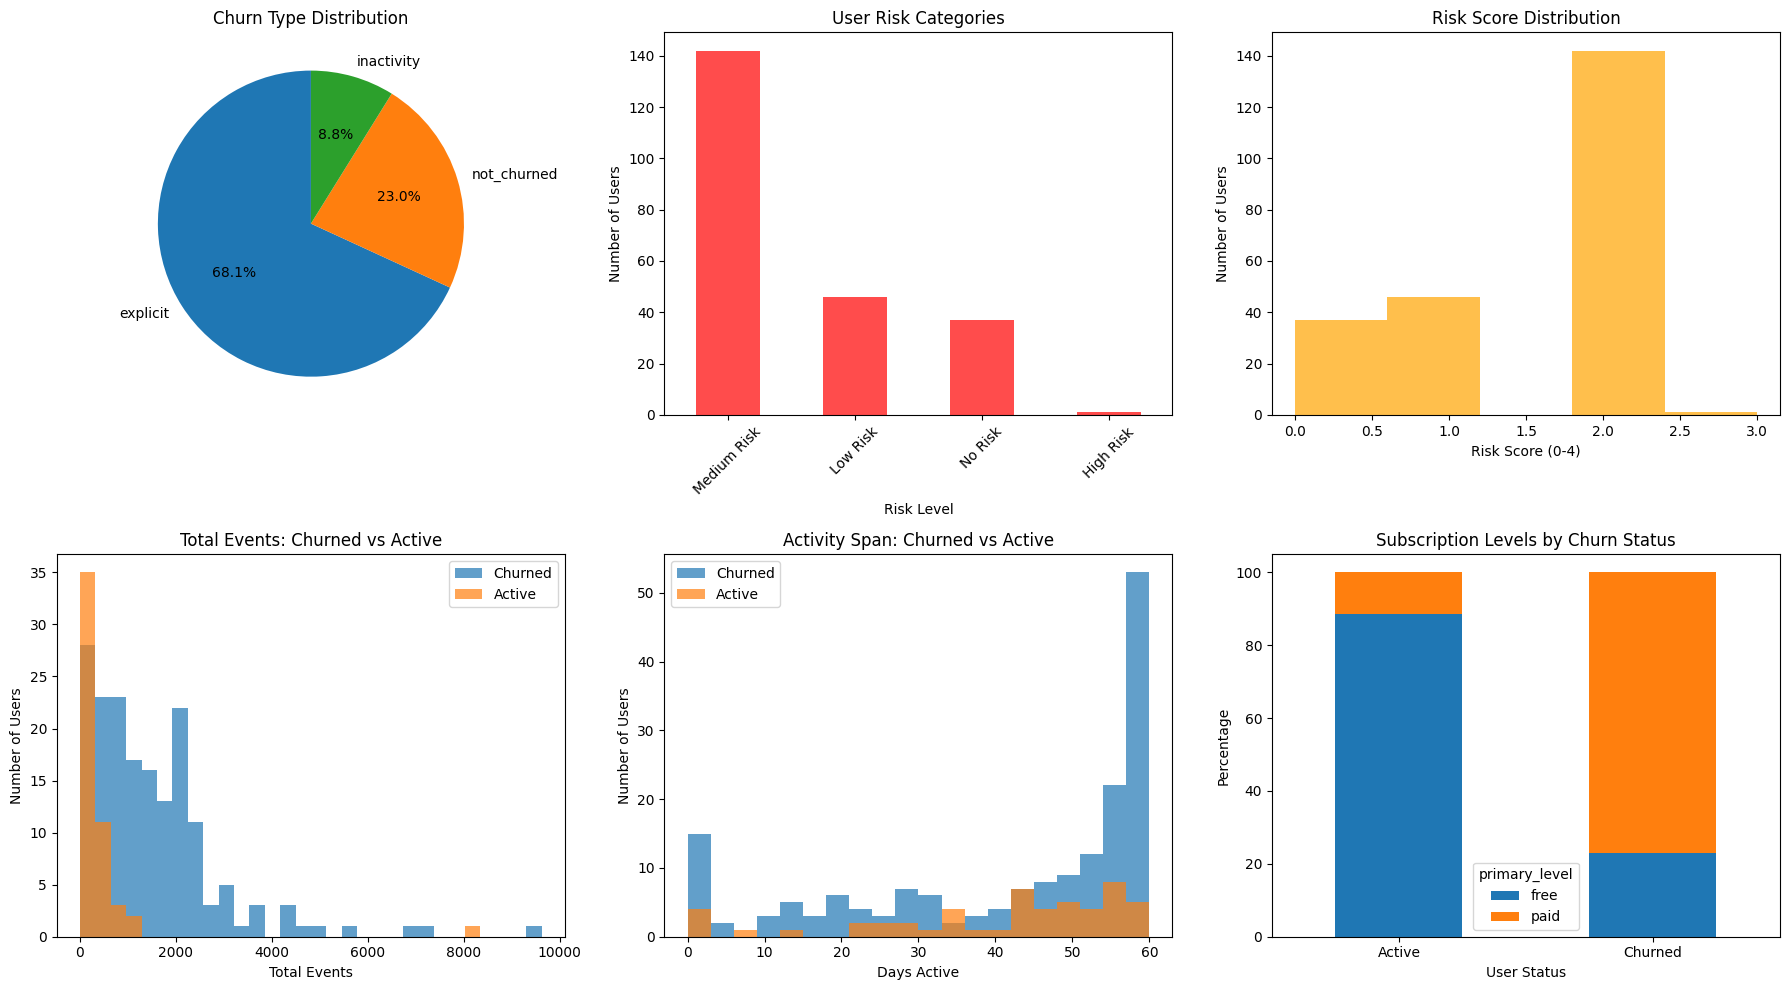


💡 Key Risk Insights:
• 154 users showed explicit churn intent
• High-risk users: 1 users need immediate attention
• Churned users have 1512 avg events vs 449 for active users
• Paid users have the highest churn rate: 95.7%


In [30]:
# Comprehensive churn analysis and risk identification
from churn_definition import ChurnDefinition

print("⚠️  CHURN SIGNALS & RISK ANALYSIS")
print("=" * 50)

# Explicit churn signals
downgrade_events = df[df['page'].str.contains('Downgrade', na=False)]
downgrade_users = downgrade_events['userId'].unique()
submit_downgrade_users = df[df['page'] == 'Submit Downgrade']['userId'].unique()

print(f"🚨 Explicit Churn Signals:")
print(f"  • Users with downgrade events: {len(downgrade_users)} ({len(downgrade_users)/len(user_summary)*100:.1f}%)")
print(f"  • Users who submitted downgrades: {len(submit_downgrade_users)} ({len(submit_downgrade_users)/len(user_summary)*100:.1f}%)")
print(f"  • Total downgrade events: {len(downgrade_events):,}")

# Subscription level changes over time
level_changes = df.groupby('userId')['level'].apply(list).reset_index()
level_changes['level_transitions'] = level_changes['level'].apply(lambda x: len(set(x)) > 1)
level_change_users = level_changes[level_changes['level_transitions']]['userId'].values

print(f"  • Users with subscription changes: {len(level_change_users)} ({len(level_change_users)/len(user_summary)*100:.1f}%)")

# Apply churn definition
churn_def = ChurnDefinition(inactivity_days=30)
churn_labels = churn_def.create_churn_labels(df)

print(f"\n🎯 Churn Classification (30-day inactivity threshold):")
churn_summary = churn_labels['churn_type'].value_counts()
for churn_type, count in churn_summary.items():
    print(f"  • {churn_type}: {count} users ({count/len(churn_labels)*100:.1f}%)")

total_churned = churn_labels['is_churned'].sum()
print(f"\n📊 Overall Churn Rate: {total_churned}/{len(churn_labels)} = {total_churned/len(churn_labels)*100:.1f}%")

# Risk factor analysis
risk_analysis = user_summary.copy()
risk_analysis['has_downgrade'] = risk_analysis['userId'].isin(downgrade_users)
risk_analysis['level_changes'] = risk_analysis['userId'].isin(level_change_users)
risk_analysis['low_activity'] = risk_analysis['activity_segment'] == 'Low Activity'
risk_analysis['short_tenure'] = risk_analysis['activity_span_days'] < 7

# Calculate risk score
risk_factors = ['has_downgrade', 'level_changes', 'low_activity', 'short_tenure']
risk_analysis['risk_score'] = risk_analysis[risk_factors].sum(axis=1)

def categorize_risk(score):
    if score >= 3:
        return 'High Risk'
    elif score >= 2:
        return 'Medium Risk' 
    elif score >= 1:
        return 'Low Risk'
    else:
        return 'No Risk'

risk_analysis['risk_category'] = risk_analysis['risk_score'].apply(categorize_risk)

print(f"\n🎯 User Risk Distribution:")
risk_dist = risk_analysis['risk_category'].value_counts()
for risk, count in risk_dist.items():
    print(f"  • {risk}: {count} users ({count/len(risk_analysis)*100:.1f}%)")

# Behavior comparison: churned vs active users
churned_users = churn_labels[churn_labels['is_churned'] == 1]['userId'].values
active_users = churn_labels[churn_labels['is_churned'] == 0]['userId'].values

churned_behavior = user_summary[user_summary['userId'].isin(churned_users)]
active_behavior = user_summary[user_summary['userId'].isin(active_users)]

print(f"\n📊 CHURNED vs ACTIVE USER COMPARISON:")
print(f"{'Metric':<25} {'Churned (Avg)':<15} {'Active (Avg)':<15} {'Difference'}")
print("-" * 70)

metrics = ['total_events', 'unique_sessions', 'activity_span_days', 'events_per_day']
for metric in metrics:
    churned_avg = churned_behavior[metric].mean()
    active_avg = active_behavior[metric].mean()
    difference = ((churned_avg - active_avg) / active_avg * 100) if active_avg > 0 else 0
    print(f"{metric:<25} {churned_avg:<15.1f} {active_avg:<15.1f} {difference:+.1f}%")

# Subscription analysis by churn status (fix the KeyError)
subscription_levels = user_summary['primary_level'].unique()
print(f"\nAvailable subscription levels: {subscription_levels}")

churn_by_sub = pd.crosstab(
    risk_analysis['primary_level'], 
    risk_analysis['userId'].isin(churned_users)
)

print(f"\nChurn by Subscription Level:")
for level in subscription_levels:
    if level in churn_by_sub.index:
        churned_count = churn_by_sub.loc[level, True] if True in churn_by_sub.columns else 0
        total_count = churn_by_sub.loc[level, :].sum()
        churn_rate_level = (churned_count / total_count * 100) if total_count > 0 else 0
        print(f"  • {level.title()} users: {churned_count}/{total_count} churned ({churn_rate_level:.1f}%)")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Churn type distribution
churn_summary.plot(kind='pie', ax=axes[0,0], autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Churn Type Distribution')
axes[0,0].set_ylabel('')

# Risk category distribution
risk_dist.plot(kind='bar', ax=axes[0,1], color='red', alpha=0.7)
axes[0,1].set_title('User Risk Categories')
axes[0,1].set_xlabel('Risk Level')
axes[0,1].set_ylabel('Number of Users')
axes[0,1].tick_params(axis='x', rotation=45)

# Risk score distribution
axes[0,2].hist(risk_analysis['risk_score'], bins=5, alpha=0.7, color='orange')
axes[0,2].set_title('Risk Score Distribution')
axes[0,2].set_xlabel('Risk Score (0-4)')
axes[0,2].set_ylabel('Number of Users')

# Events comparison
event_comparison = pd.DataFrame({
    'Churned': churned_behavior['total_events'],
    'Active': active_behavior['total_events']
})
event_comparison.plot(kind='hist', ax=axes[1,0], bins=30, alpha=0.7)
axes[1,0].set_title('Total Events: Churned vs Active')
axes[1,0].set_xlabel('Total Events')
axes[1,0].set_ylabel('Number of Users')

# Activity span comparison
span_comparison = pd.DataFrame({
    'Churned': churned_behavior['activity_span_days'],
    'Active': active_behavior['activity_span_days']
})
span_comparison.plot(kind='hist', ax=axes[1,1], bins=20, alpha=0.7)
axes[1,1].set_title('Activity Span: Churned vs Active')
axes[1,1].set_xlabel('Days Active')
axes[1,1].set_ylabel('Number of Users')

# Subscription level by churn status (fixed)
churn_sub_crosstab = pd.crosstab(
    risk_analysis['userId'].isin(churned_users).map({True: 'Churned', False: 'Active'}),
    risk_analysis['primary_level'],
    normalize='index'
) * 100

churn_sub_crosstab.plot(kind='bar', ax=axes[1,2], stacked=True)
axes[1,2].set_title('Subscription Levels by Churn Status')
axes[1,2].set_xlabel('User Status')
axes[1,2].set_ylabel('Percentage')
axes[1,2].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

# Summary insights (fixed)
print(f"\n💡 Key Risk Insights:")
print(f"• {len(downgrade_users)} users showed explicit churn intent")
print(f"• High-risk users: {risk_dist.get('High Risk', 0)} users need immediate attention")
print(f"• Churned users have {churned_behavior['total_events'].mean():.0f} avg events vs {active_behavior['total_events'].mean():.0f} for active users")

# Additional subscription analysis
if len(subscription_levels) > 0:
    highest_churn_level = None
    highest_churn_rate = 0
    for level in subscription_levels:
        if level in churn_by_sub.index:
            churned_count = churn_by_sub.loc[level, True] if True in churn_by_sub.columns else 0
            total_count = churn_by_sub.loc[level, :].sum()
            churn_rate_level = (churned_count / total_count) if total_count > 0 else 0
            if churn_rate_level > highest_churn_rate:
                highest_churn_rate = churn_rate_level
                highest_churn_level = level
    
    if highest_churn_level:
        print(f"• {highest_churn_level.title()} users have the highest churn rate: {highest_churn_rate*100:.1f}%")